In [1]:
# Cell 1: set dataset path (edit if your CSV has a different name/location)
DATA_PATH = "dialogueText.csv"

In [2]:
# Cell 2: lightweight imports (standard libs + pandas/matplotlib)
import os
import re
import string
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

print("Basic imports ready.")

Basic imports ready.


In [3]:
# Cell 3: load CSV and show shape/head
path = Path(DATA_PATH)
if not path.exists():
    raise FileNotFoundError(f"{path} not found. Update DATA_PATH or place the file in the notebook directory.")

df = pd.read_csv(path)
print("Loaded:", path)
print("Shape:", df.shape)
df.head()

Loaded: dialogueText.csv
Shape: (1038324, 6)


,folder,dialogueID,date,from,to,text
0,3,126125.tsv,2008-04-23T14:55:00.000Z,bad_image,NaN,"Hello folks, please help me a bit with the fol..."
1,3,126125.tsv,2008-04-23T14:56:00.000Z,bad_image,NaN,Did I choose a bad channel? I ask because you ...
2,3,126125.tsv,2008-04-23T14:57:00.000Z,lordleemo,bad_image,the second sentence is better english and we...
3,3,64545.tsv,2009-08-01T06:22:00.000Z,mechtech,NaN,Sock Puppe?t
4,3,64545.tsv,2009-08-01T06:22:00.000Z,mechtech,NaN,WTF?


In [4]:
# Cell 4: minimal cleanup: drop 'folder'/'dialogueID' if present, drop rows without text
for c in ["folder", "dialogueID"]:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

if "text" not in df.columns:
    raise KeyError("Expected column named 'text'. Rename or update code to point to your text column.")

df = df.dropna(subset=["text"]).reset_index(drop=True)
print("After cleaning shape:", df.shape)

After cleaning shape: (1038237, 4)


In [5]:
# Cell 5: quick peek & basic counts
print("Sample 5 messages:")
for i, t in enumerate(df["text"].sample(5, random_state=1).tolist(), 1):
    print(f"{i}.", t[:200])   # print first 200 chars for preview
print("Total rows:", len(df))
print("Unique messages:", df["text"].nunique())

Sample 5 messages:
1. hi. i want a minimal audio player whose sole purpose is to play audio files, and NOTHING else
2.   that was way easier than I thought it would be ... thanks much
3. do you know where i can put my .debs?
4. awesome, thanks
5. what kind of problems are possible to happen related to if I install ubuntu 11.10 beta 2 and just upgrade it regularly through synaptic, instead of waiting for ubuntu 11.10 and do the same?
Total rows: 1038237
Unique messages: 863907


In [6]:
# Cell 6: small cleaning helpers - lowercase, urls, mentions/hashtags
def to_lower(s):
    return s.lower()

def remove_urls(s):
    return re.sub(r"http\S+|www\.\S+|https\S+", "", s)

def remove_mentions_hashtags(s):
    s = re.sub(r"@\w+", "", s)   # remove @mentions
    s = re.sub(r"#\w+", "", s)   # remove #hashtags
    return s

In [7]:
# Cell 7: punctuation, numbers, whitespace normalization
PUNCT_TABLE = str.maketrans("", "", string.punctuation)

def remove_punct(s):
    return s.translate(PUNCT_TABLE)

def remove_numbers(s):
    return re.sub(r"\d+", "", s)

def normalize_whitespace(s):
    return re.sub(r"\s+", " ", s).strip()

In [8]:
# Cell 8: NLTK import/install & resources + stopword/lemmatizer helpers
try:
    import nltk
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk"])
    import nltk

# Download only what we'll use
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

STOPWORDS = set(stopwords.words("english"))
CUSTOM_STOPWORDS = {"hi","hello","hey","im","dont","u","you","thanks","thank","want","like","know","pls","please"}
STOPWORDS |= CUSTOM_STOPWORDS

LEMMATIZER = WordNetLemmatizer()

def remove_stopwords_and_lemmatize(s):
    tokens = word_tokenize(s)
    tokens = [t for t in tokens if t.lower() not in STOPWORDS]
    lemmas = [LEMMATIZER.lemmatize(t) for t in tokens]
    return " ".join(lemmas)

[nltk_data] Downloading package punkt to C:\Users\RITAM
[nltk_data]     PAL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\RITAM
[nltk_data]     PAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\RITAM
[nltk_data]     PAL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\RITAM
[nltk_data]     PAL\AppData\Roaming\nltk_data...


In [9]:
# Cell 9: single small function that composes the above steps
def preprocess_text(s):
    if not isinstance(s, str):
        return ""
    s = to_lower(s)
    s = remove_urls(s)
    s = remove_mentions_hashtags(s)
    s = remove_punct(s)
    s = remove_numbers(s)
    s = normalize_whitespace(s)
    s = remove_stopwords_and_lemmatize(s)
    return s

In [10]:
# Cell 10: apply preprocessing to a sample to keep runtime reasonable
SAMPLE_N = 50000
n = min(SAMPLE_N, len(df))
df_sample = df.sample(n=n, random_state=42).reset_index(drop=True)

# Create clean_text column (this is the expensive op)
df_sample["clean_text"] = df_sample["text"].apply(preprocess_text)

print("Completed preprocessing on sample of", n)
df_sample[["text", "clean_text"]].head()

Completed preprocessing on sample of 50000


,text,clean_text
0,!enter | Newb`s,enter newbs
1,How do I activate the root account?,activate root account
2,maybe xmms ?,maybe xmms
3,"Dekela, you did?",dekela
4,ok if i install windows,ok install window


In [11]:
# Cell 11: word & character length stats
df_sample["word_count"] = df_sample["clean_text"].apply(lambda s: len(s.split()) if s else 0)
df_sample["char_count"] = df_sample["clean_text"].apply(len)

print(f"Average words/message: {df_sample['word_count'].mean():.2f}")
print(f"Median words/message:  {df_sample['word_count'].median()}")
df_sample[["clean_text", "word_count", "char_count"]].head()

Average words/message: 5.27
Median words/message:  4.0


,clean_text,word_count,char_count
0,enter newbs,2,11
1,activate root account,3,21
2,maybe xmms,2,10
3,dekela,1,6
4,ok install window,3,17


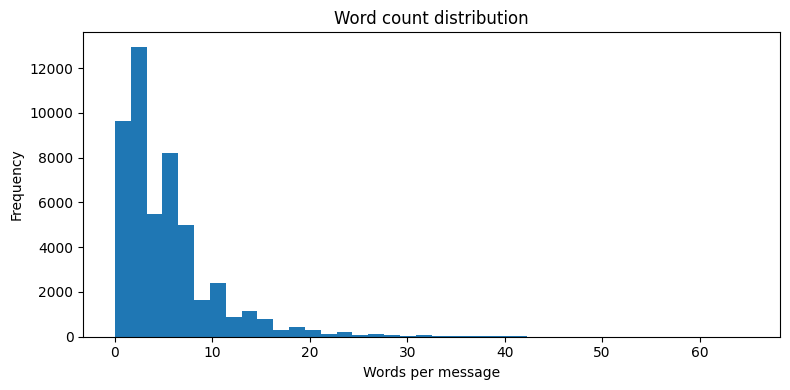

In [12]:
# Cell 12: histogram of word counts (matplotlib)
plt.figure(figsize=(8,4))
plt.hist(df_sample["word_count"], bins=40)
plt.title("Word count distribution")
plt.xlabel("Words per message")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

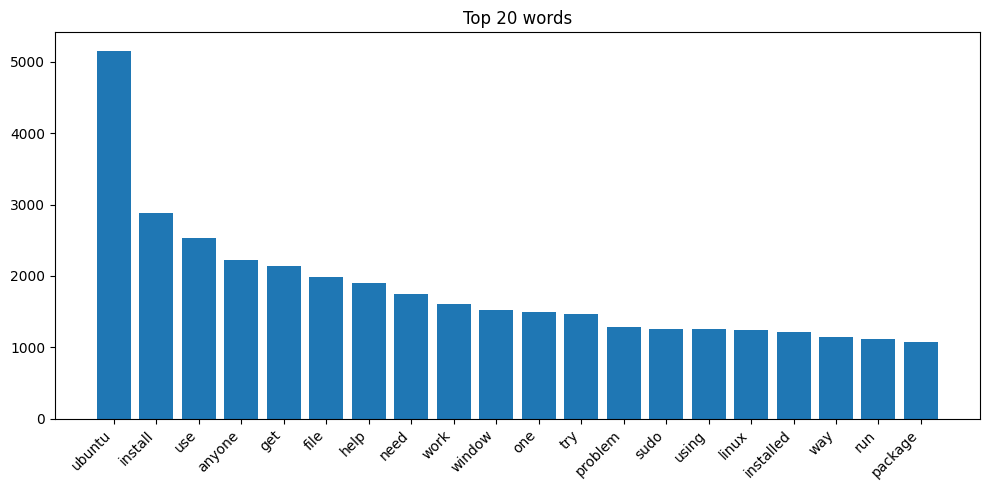

In [14]:
# Cell 13: top 20 most common words from clean_text
counter = Counter()
for s in df_sample["clean_text"]:
    if s:
        counter.update(s.split())

top20 = counter.most_common(20)
top20_df = pd.DataFrame(top20, columns=["word", "count"])
plt.figure(figsize=(10,5))
plt.bar(top20_df["word"], top20_df["count"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 words")
plt.tight_layout()
plt.show()


In [15]:
# Cell 15: sentiment analysis using VADER (install only if missing)
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "vaderSentiment"])
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# compute compound score and simple label
df_sample["sentiment_compound"] = df_sample["clean_text"].apply(lambda s: analyzer.polarity_scores(s)["compound"])
def label_sentiment(c):
    if c >= 0.05:
        return "positive"
    if c <= -0.05:
        return "negative"
    return "neutral"

df_sample["sentiment_label"] = df_sample["sentiment_compound"].apply(label_sentiment)

print("Sentiment label counts:")
print(df_sample["sentiment_label"].value_counts())
df_sample[["clean_text", "sentiment_compound", "sentiment_label"]].head()

Sentiment label counts:
neutral     31778
positive    12482
negative     5740
Name: sentiment_label, dtype: int64


,clean_text,sentiment_compound,sentiment_label
0,enter newbs,0.000,neutral
1,activate root account,0.000,neutral
2,maybe xmms,0.000,neutral
3,dekela,0.000,neutral
4,ok install window,0.296,positive


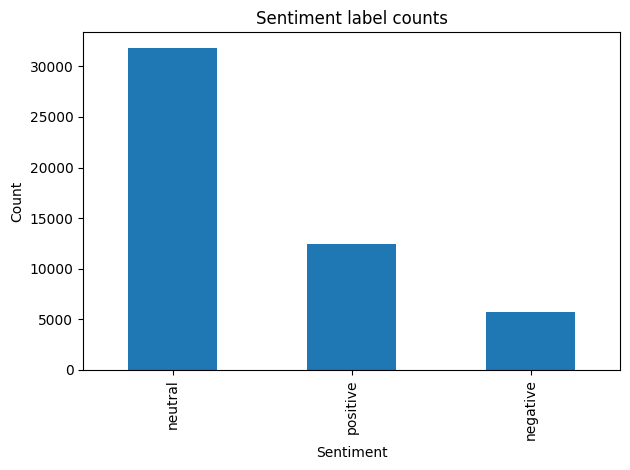

In [16]:
# Cell 16: plot sentiment label distribution
df_sample["sentiment_label"].value_counts().plot(kind="bar")
plt.title("Sentiment label counts")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()